# Mountaincar MDP

This notebook explores the mountain car MDP challenge, and how to solve it using Deep Q-networks. In the future, it may be compared to linear function approximators for the action-value function.

## 1) Exploring the state space

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
env = gym.make('MountainCar-v0')
print(env.action_space.n)
print(env.observation_space.shape)

In [ ]:
env.seed(12)
print(env.reset())
env.render()
print(env.step(0))
print(env.step(0))
print(env.step(0)[2])
v = []
for j in range(1000):
    step = env.step(2)
    v.append(step[0][1])
    if step[2]:
        print(f"Done at iteration {j}, with state {step[0]}!")
        env.reset()

In [ ]:
plt.plot(v)

In [ ]:
print(env.reset())
env.render()

Action space:
* 0: left accelation
* 1: no acceleration
* 2: right acceleration

Rewards: -1 until reaching the destination.

Always resets after 200 steps.

x-pos -0.5 is at the bottom of the valley?

## 2) Solving the MDP: DQN

In [1]:
import numpy as np
import random
import gym
import time
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import models 
from keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as c
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook


Using TensorFlow backend.
C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\tenso

In [2]:
class DQNagent:
    """
    An implementation of a Deep Q-Network agent (DQN) to tackle the Mountain Car example. 
    The agent uses experience replay and fixed training targets.
    
    With some minor adjustment to this code, the agent can in principle attempt to tackle any MDP with a finite amount of actions.
    
    For parameter info and default values, see the __init__ function.
    """
    def __init__(self, env, track_Q = False, learning_rate = 0.001):
        
        # Hyperparameters for the algorithm:
        self.epsilon = .9                   # Exploration rate.
        self.epsilon_decay = .95            # Decay of the exploration rate, multiplied with epsilon every training episode.
        self.epsilon_min = .1               # Minimal exploration rate.
        self.lr = learning_rate             # Learning Rate.
        self.gamma = .99                    # The discounting factor of the Markov Decision Process.
        self.batch_size = 32                # The number of samples used in every training batch during experience replay.
    
        # Environment specification:
        self.env = env
        self.num_actions = env.action_space.n
        self.num_state_dim = env.observation_space.shape[0]
        
        # Q-Network specifications - 2 hidden layers with relu followed by a linear layer,
        #                            the network takes a state and outputs an estimated Q-value for every action.
        self.num_nodes_layer1 = 24          # The number of nodes in the first hidden layer of the network.
        self.num_nodes_layer2 = 48          # The number of nodes in the second hidden layer of the network.
        self.model = self.init_model()
        self.target_model = self.init_model() # Fixed targets for the network updates.
        self.target_model.set_weights(self.model.get_weights())
         
        # Memory for replay
        self.memory = deque(maxlen = 2000)  # A deque object is a list with O(1) append and pop operations.
        # TODO: it was noted in a medium article that the sampler on the deque object does not have fast random indexing. Another implementation could be used to speed this up - although this may not be a bottleneck.
        
        # Metrics to evaluate the agent
        self.training_epis = 0               # Number of training iterations so far.
        self.num_steps = []                 # Number of time steps needed to complete the episode, for each episode.
        self.values = []                    # Total reward acrued for every episode.
        self.max_X_list = []                # A list keeping track of the maximal x position in every training episode.
        self.track_Q = track_Q              # A boolean indicating whether the agent keeps track of the Q-values at 2 states over all episodes.
        self.xstart_vpos = [[],[],[]]       # List of Q-estimates in x = -0.5 (start position) and v = 0.01 over the training iterations.
        self.xstart_vneg = [[],[],[]]       # List of Q-estimates in x = -0.5 (start position) and v = -0.01 over the training iterations.
 

    def init_model(self):
        """
        Creates a Q-network using keras, taking states and outputting an array of Q-values for every action.
        It consists of 2 fully connected hidden layers with relu units, and a final linear layer.
        
        The parameters get learned with the Adam optimizer.
        """
        model = Sequential()
        model.add(Dense(units = self.num_nodes_layer1, activation = 'relu', input_dim = self.num_state_dim))
        model.add(Dense(units = self.num_nodes_layer2, activation = 'relu'))
        model.add(Dense(self.num_actions, activation = 'linear'))
        model.compile(loss = 'mse', 
                      optimizer = Adam(lr = self.lr))
        return model

    
    def act(self, state):
        """
        Given the Q-training network and a state, this function chooses an epsilon-greedy action.
        
        Note: state needs to be of shape [1, num_state_dim] for the keras predict function.
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.num_actions)
        else:
            return np.argmax( self.model.predict(state)[0] )

        
    def remember(self, state, action, reward, new_state, done):
        """
        Adds a (state, action, reward, new_state, done) sequence to the replay memory.
        """
        self.memory.append((state, action, reward, new_state, done))

        
    def experience_replay(self):
        """
        This function implements the experience replay algorithm. Given the memory, 
        the agent samples 'self.batch_size' transition sequences at random and uses those to train the network.
        Note: fixed targets are used. - Can investigate the benefit of this still.
        
        If not enough sequences are in the memory buffer yet, no training is performed.
        """
        if len(self.memory) < self.batch_size:
            return
        
        mini_batch = random.sample(self.memory, self.batch_size)
        states = []
        newStates = []
        for state, action, reward, new_state, done in mini_batch:
            states.append(state)
            newStates.append(new_state)
        
        newStates = np.array(newStates).reshape([self.batch_size, self.num_state_dim])
        states = np.array(states).reshape([self.batch_size, self.num_state_dim])
      
        targets = self.model.predict(states)
        newStateTarget = self.target_model.predict(newStates)
                
        i = 0
        for state, action, reward, new_state, done in mini_batch:            
            if done:
                targets[i][action] = reward
            else:
                targets[i][action] = reward + self.gamma * np.amax(newStateTarget[i,])
            i+=1
     
        self.model.fit(states, targets, epochs = 1, verbose = 0) # keras requires multidimensional targets. The ones corresponding to the actions not taken cancel out.
        
    def learn_mepis(self, num_epis, verbose = True):
        """
        This function implements agent learning over multiple episodes, 'num_epis' in total.
        """
        
        end_it = self.training_epis + num_epis # The total amount of episodes the agent will have trained on after this function finishes.
        
        for epis in range(num_epis):
            epis_time = time.time()
            state = np.reshape(self.env.reset(), [1, self.num_state_dim])
            self.values.append(0)
            max_X = state[0,0]
            for t in range(201):
                action = self.act(state)
                new_state, reward, done, _ = self.env.step(action)
                new_state = np.reshape(new_state, [1,2])
                
                # "Cheat" that was used in one code example:
                #if new_state[0, 0] > 0.5:
                #    reward = 10

                self.remember(state, action, reward, new_state, done)
                self.experience_replay()
                state = new_state
                
                # Updates for some of the evaluation metrics:
                self.values[-1] += (self.gamma ** t) * reward
                if state[0,0] > max_X:
                    max_X = state[0,0]
                    
                if done:
                    self.num_steps.append(t+1)
                    self.max_X_list.append(max_X)
                    break
                    
            self.target_model.set_weights(self.model.get_weights())
            
            # Updates for some of the evaluation metrics:
            self.training_epis += 1
            if self.track_Q:
                self.track_Q_fct()
                
            # Some diagnostic information to be printed:
            if verbose:
                print(f"\r{self.training_epis}/{end_it} episodes. Episode time: {time.time() - epis_time}. Max x: {max_X}, t = {self.num_steps[-1]}.", end = '')
            
            # Update the exploration rate:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
 
    #########################################################
    ## In the following, only diagnostic functions follow. ##
    #########################################################            
    def render_greedy_episode(self):
        """
        Renders a greedy episode based on the current Q-network.
        """
        state = np.reshape(env.reset(), [1,2])
        for t in range(200):
            action = np.argmax(self.model.predict(state)[0])
            state, _, done, _ = env.step(action)
            state = np.reshape(state, [1,2])
            if done:
                break
            env.render()
                
    def track_Q_fct(self):
        """
        Track the Q values over the different episodes at [-0.5, 0.01] and [-0.5, -0.01].
        """
        vpos = self.model.predict(np.array([-0.5, 0.01]).reshape([1,2]))
        vneg = self.model.predict(np.array([-0.5, -0.01]).reshape([1,2]))
        for i in range(3):
            self.xstart_vpos[i].append(vpos[0][i])
            self.xstart_vneg[i].append(vneg[0][i])
                
    def plot_Q(self, separate_plots = False, best_action = True):
        """
        This function plots the Q-values over the state space and provides a plot of the greedy policy based on that network.
        """
        print(f"Number of training episodes: {self.training_epis}.")
        gridX = np.linspace(-1.5, .5, 50)
        gridY = np.linspace(-.06, .06, 50)
        X, Y = np.meshgrid(gridX, gridY)
        inputGrid = np.transpose([np.tile(gridX, len(gridY)), np.repeat(gridY, len(gridX))])
        Q = self.model.predict(inputGrid)
        
        colors = ['y', 'g', 'b']

        fig = plt.figure()
        ax = fig.gca(projection='3d')
        for dim in range(3):
            surf = ax.plot_surface(X, Y, np.reshape(Q[:,dim], [50,50]), 
                       linewidth=0, antialiased=False, color = colors[dim], alpha = .33)
        plt.xlabel('x')
        plt.ylabel('v')
        plt.title(f"All actions")
        plt.show()
        for dim in range(3):
            print(f"Action {dim}: color = {colors[dim]}.")
        print("\nNote that this plot doesn't show clearly which action is largest. The surfaces are just plotted on top of each other. Refer to the best action plot for this:")
        
        if separate_plots:
            for dim in range(3):
                fig = plt.figure()
                ax = fig.gca(projection='3d')
                surf = ax.plot_surface(X, Y, np.reshape(Q[:,dim], [50,50]), 
                               linewidth=0, antialiased=False, color = colors[dim])
                plt.xlabel('x')
                plt.ylabel('v')
                plt.title(f"Action {dim}")
                plt.show()
        
        if best_action:
            fig = plt.figure()
            #print(np.reshape(np.argmax(Q, axis = 1), [50,50]))
            cMap = c.ListedColormap(colors)
            heatmap = plt.pcolormesh(X,Y, np.reshape(np.argmax(Q, axis = 1), [50,50]), cmap = cMap, vmin = 0, vmax = 2) #pcolormesh?
            plt.xlabel('x')
            plt.ylabel('v')
            plt.title(f"Best Action")
            plt.show()
                        
    def plot_max_X(self, start_it = 0):
        """
        Plots the maximal x-value that was attained during the different training episodes.
        """
        fig = plt.figure()
        grid = np.arange(start_it, self.training_epis)
        plt.plot(grid, self.max_X_list[start_it:])
        plt.title("Maximum x-value reached per episode")
        plt.show()
        
    def plot_num_steps(self, start_it = 0):
        """
        Plots the number of steps needed to complete the episodes during the different training episodes.
        """
        fig = plt.figure()
        grid = np.arange(start_it, self.training_epis)
        plt.plot(grid, self.num_steps[start_it:])
        plt.title("Number of steps needed to complete the episode (max = 200)")
        plt.show()
    
    def plot_track_Q(self, start_it = 0):
        """
        Plots the evolution of the Q-values at [x, v] = [-0.5, .01], and = [-0.5, -0.01].
        """
        fig = plt.figure()
        grid = np.arange(start_it, self.training_epis)
        plt.plot(grid, self.xstart_vpos[0][start_it:], 'y', grid, self.xstart_vpos[1][start_it:], 'g', grid, self.xstart_vpos[2][start_it:], 'b')
        plt.title("Q-values at x = -0.5, v = 0.01, per episode.")
        plt.show()
        
        fig = plt.figure()
        grid = np.arange(start_it, self.training_epis)
        plt.plot(grid, self.xstart_vneg[0][start_it:], 'y', grid, self.xstart_vneg[1][start_it:], 'g', grid, self.xstart_vneg[2][start_it:], 'b')
        plt.title("Q-values at x = -0.5, v = -0.01, per episode.")
        plt.show()
                 
    def save(self, name):
        """
        Saves the network weights externally.
        """
        self.model.save_weights(name)
        
    def load(self, name):
        """
        Loads externally saved network weights.
        """
        self.model.load_weights(name)
        self.target_model.set_weights(self.model.get_weights())

        

Note that the Q-values for the different actions are all linearly dependent on the same learned non-linear features. Explore different architectures?

In [3]:
env = gym.make('MountainCar-v0')
agent = DQNagent(env, track_Q = True)

Instructions for updating:
Colocations handled automatically by placer.


Before training, this is what our Q-values look like - pretty random, as should be the case:

Number of training episodes: 0.


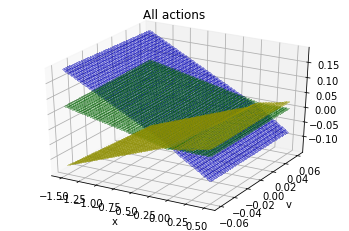

Action 0: color = y.
Action 1: color = g.
Action 2: color = b.

Note that this plot doesn't show clearly which action is largest. The surfaces are just plotted on top of each other. Refer to the best action plot for this:


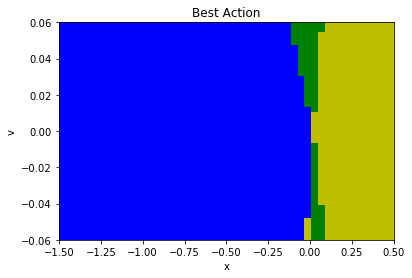

In [4]:
agent.plot_Q(separate_plots = False)

**Training:**

The following cell can be run multiple times, and it will attempt to improve the already learned Q-network every time.

In [6]:
#%%prun

num_epis = 300              # Number of episodes to train on.
agent.learn_mepis(num_epis)

354/354 episodes. Episode time: 0.47000718116760254. Max x: 0.5276554864996891, t = 162...

Number of training episodes: 354.


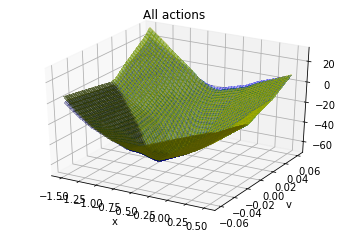

Action 0: color = y.
Action 1: color = g.
Action 2: color = b.

Note that this plot doesn't show clearly which action is largest. The surfaces are just plotted on top of each other. Refer to the best action plot for this:


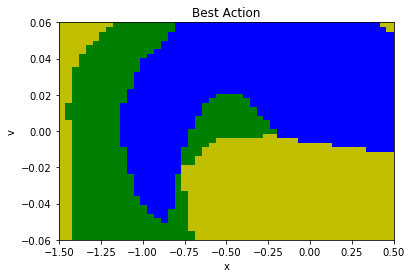

In [7]:
agent.plot_Q()

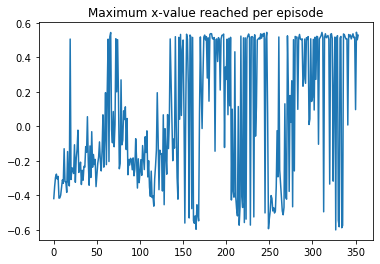

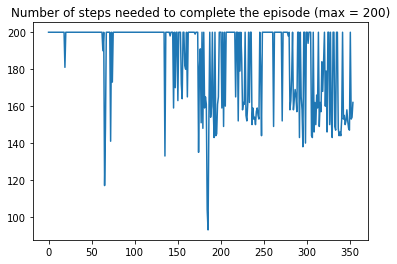

In [8]:
agent.plot_max_X()
agent.plot_num_steps()

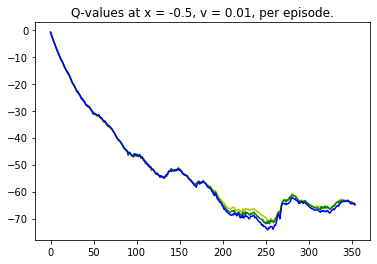

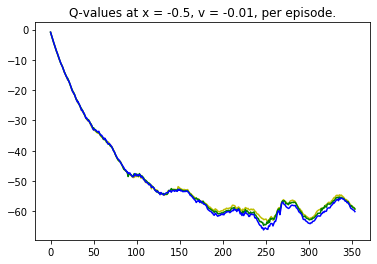

In [9]:
agent.plot_track_Q(start_it = 0)

Now we can test a greedy policy:

In [10]:
agent.render_greedy_episode()   

In [ ]:
print(agent.epsilon)
print(agent.training_its)

Some more notes:

* DQN in the paper Human-level control ... uses Huber loss instead of mse in training. RMSProp as well. See [this medium post](https://becominghuman.ai/beat-atari-with-deep-reinforcement-learning-part-2-dqn-improvements-d3563f665a2c).

## 3) Online code for DQN as a comparison:

In [ ]:
#############################
#if you want to use GPU to boost, use these code.  

# import tensorflow as tf
# import keras
# config = tf.ConfigProto( device_count = {'GPU': 2 , 'CPU': 1} ) 
# sess = tf.Session(config=config) 
# keras.backend.set_session(sess)

#############################


class MountainCarTrain:
    def __init__(self,env):
        self.env=env
        self.gamma=0.99

        self.epsilon = 1
        self.epsilon_decay = 0.05

        self.epsilon_min=0.01


        self.learingRate=0.001

        self.replayBuffer=deque(maxlen=20000)
        self.trainNetwork=self.createNetwork()

        self.episodeNum=400

        self.iterationNum=201 #max is 200

        self.numPickFromBuffer=32

        self.targetNetwork=self.createNetwork()

        self.targetNetwork.set_weights(self.trainNetwork.get_weights())
        
        self.max_X_list = []

    def createNetwork(self):
        model = models.Sequential()
        state_shape = self.env.observation_space.shape

        model.add(layers.Dense(24, activation='relu', input_shape=state_shape))
        model.add(layers.Dense(48, activation='relu'))
        model.add(layers.Dense(self.env.action_space.n,activation='linear'))
        # model.compile(optimizer=optimizers.RMSprop(lr=self.learingRate), loss=losses.mean_squared_error)
        model.compile(loss='mse', optimizer=Adam(lr=self.learingRate))
        return model

    def getBestAction(self,state):

        self.epsilon = max(self.epsilon_min, self.epsilon)

        if np.random.rand(1) < self.epsilon:
            action = np.random.randint(0, 3)
        else:
            action=np.argmax(self.trainNetwork.predict(state)[0])

        return action

    

    def trainFromBuffer_Boost(self):
        if len(self.replayBuffer) < self.numPickFromBuffer:
            return
        samples = random.sample(self.replayBuffer,self.numPickFromBuffer)
        npsamples = np.array(samples)
        states_temp, actions_temp, rewards_temp, newstates_temp, dones_temp = np.hsplit(npsamples, 5)
        states = np.concatenate((np.squeeze(states_temp[:])), axis = 0)
        rewards = rewards_temp.reshape(self.numPickFromBuffer,).astype(float)
        targets = self.trainNetwork.predict(states)
        newstates = np.concatenate(np.concatenate(newstates_temp))
        dones = np.concatenate(dones_temp).astype(bool)
        notdones = ~dones
        notdones = notdones.astype(float)
        dones = dones.astype(float)
        Q_futures = self.targetNetwork.predict(newstates).max(axis = 1)
        targets[(np.arange(self.numPickFromBuffer), actions_temp.reshape(self.numPickFromBuffer,).astype(int))] = rewards * dones + (rewards + Q_futures * self.gamma)*notdones
        self.trainNetwork.fit(states, targets, epochs=1, verbose=0)



    def trainFromBuffer(self):
        if len(self.replayBuffer) < self.numPickFromBuffer:
            return

        samples = random.sample(self.replayBuffer,self.numPickFromBuffer)

        states = []
        newStates=[]
        for sample in samples:
            state, action, reward, new_state, done = sample
            states.append(state)
            newStates.append(new_state)

        newArray = np.array(states)
        states = newArray.reshape(self.numPickFromBuffer, 2)

        newArray2 = np.array(newStates)
        newStates = newArray2.reshape(self.numPickFromBuffer, 2)

        targets = self.trainNetwork.predict(states)
        new_state_targets=self.targetNetwork.predict(newStates)
        

        i=0
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = targets[i]
            if done:
                target[action] = reward
            else:
                Q_future = max(new_state_targets[i])
                target[action] = reward + Q_future * self.gamma
            i+=1

        self.trainNetwork.fit(states, targets, epochs=1, verbose=0)


    def orginalTry(self,currentState,eps):
        rewardSum = 0
        max_position=-99

        for i in range(self.iterationNum):
            bestAction = self.getBestAction(currentState)

            #show the animation every 50 eps
            if eps%50==0:
                env.render()

            new_state, reward, done, _ = env.step(bestAction)

            new_state = new_state.reshape(1, 2)

            # # Keep track of max position
            if new_state[0][0] > max_position:
                max_position = new_state[0][0]


            # # Adjust reward for task completion
            if new_state[0][0] >= 0.5:
                reward += 10

            self.replayBuffer.append([currentState, bestAction, reward, new_state, done])

            #Or you can use self.trainFromBuffer_Boost(), it is a matrix wise version for boosting 
            self.trainFromBuffer()

            rewardSum += reward

            currentState = new_state

            if done:
                break

        if i >= 199:
            print("Failed to finish task in epsoide {}".format(eps))
        else:
            print("Success in epsoide {}, used {} iterations!".format(eps, i))
            self.trainNetwork.save('./trainNetworkInEPS{}.h5'.format(eps))

        #Sync
        self.max_X_list.append(max_position)
        self.targetNetwork.set_weights(self.trainNetwork.get_weights())

        print("now epsilon is {}, the reward is {} maxPosition is {}".format(max(self.epsilon_min, self.epsilon), rewardSum,max_position))
        self.epsilon -= self.epsilon_decay

    def start(self):
        print("And we've started!")
        for eps in range(self.episodeNum):
            currentState=env.reset().reshape(1,2)
            start = time.time()
            self.orginalTry(currentState, eps)
            print(f"Episode runtime: {time.time() - start}")
            
    def plot_Q(self, separate_plots = False, best_action = True):
        print(f"Number of training episodes: {self.episodeNum}")
        gridX = np.linspace(-1.5, .5, 50)
        gridY = np.linspace(-.1, .1, 50)
        X, Y = np.meshgrid(gridX, gridY)
        inputGrid = np.transpose([np.tile(gridX, len(gridY)), np.repeat(gridY, len(gridX))])
        Q = self.trainNetwork.predict(inputGrid)
        
        colors = ['y', 'g', 'b']

        fig = plt.figure()
        ax = fig.gca(projection='3d')
        for dim in range(3):
            surf = ax.plot_surface(X, Y, np.reshape(Q[:,dim], [50,50]), 
                       linewidth=0, antialiased=False, color = colors[dim], alpha = .33)
        plt.xlabel('x')
        plt.ylabel('v')
        plt.title(f"All actions")
        plt.show()
        for dim in range(3):
            print(f"Action {dim}: {colors[dim]}")
        print("Note that this plot doesn't show clearly which action is largest. The surfaces are just plotted on top of each other. Refer to the best action plot for this.")
        
        if separate_plots:
            for dim in range(3):
                fig = plt.figure()
                ax = fig.gca(projection='3d')
                surf = ax.plot_surface(X, Y, np.reshape(Q[:,dim], [50,50]), 
                               linewidth=0, antialiased=False, color = colors[dim])
                plt.xlabel('x')
                plt.ylabel('v')
                plt.title(f"Action {dim}")
                plt.show()

                
        if best_action:
            fig = plt.figure()
            print(np.reshape(np.argmax(Q, axis = 1), [50,50]))
            cMap = c.ListedColormap(colors)
            heatmap = plt.pcolormesh(X,Y, np.reshape(np.argmax(Q, axis = 1), [50,50]), cmap = cMap, vmin = 0, vmax = 2) #pcolormesh?
            plt.xlabel('x')
            plt.ylabel('v')
            plt.title(f"Best Action")
            plt.show()
            
    def plot_max_X(self, init_pos = 0):
        fig = plt.figure()
        plt.plot(self.max_X_list[init_pos:])

In [ ]:
env = gym.make('MountainCar-v0')
dqn=MountainCarTrain(env=env)
dqn.start()

In [ ]:
#%%prun
dqn.plot_Q()

In [ ]:
dqn.plot_max_X()

In [ ]:
%timeit # Runs multiple times